<a href="https://colab.research.google.com/github/AIPythonILP-teamB/AIPythonILP-teamB-Python/blob/kobayashi/data_mix_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## データのインポート

In [1]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=03e4804452b8c97397d3dd0a0277a36d98ed66cf74a421fed0c4923ec6c2c131
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


In [2]:
# 数値計算を行うライブラリ numpy をインポート
import numpy as np
# 表データを扱うライブラリ pandas をインポート
import pandas as pd
# 図や表を描画するためのライブラリをインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [3]:
weather_df = pd.read_csv('weather_data_cleaned.csv')
sales_df = pd.read_csv('sales_data_cleaned.csv')

# データ結合
df = pd.merge(sales_df, weather_df, on='日付', how='left')
df = df.drop('曜日_y', axis=1)
#欠損値の削除
df = df.dropna()

In [4]:
df.columns

Index(['日付', '曜日_x', '来客数', '総杯数', '売上合計(円)', 'ペールエール(本)', 'ペールエール(円)',
       'ラガー(本)', 'ラガー(円)', 'IPA(本)', 'IPA(円)', 'ホワイトビール(本)', 'ホワイトビール(円)',
       '黒ビール(本)', '黒ビール(円)', 'フルーツビール(本)', 'フルーツビール(円)', '平均気温(℃)',
       '降水量の合計(mm)', '日照時間(時間)', '平均風速(m/s)', '平均蒸気圧(hPa)', '平均湿度(％)',
       '平均雲量(10分比)', '最高気温(℃)', '最低気温(℃)', '1時間降水量の最大(mm)', '最大風速(m/s)',
       '最小相対湿度(％)'],
      dtype='object')

## 給料日と祝日を説明変数に



In [5]:
#日付をdatetimeに変更
df['日付'] = pd.to_datetime(df['日付'], errors='coerce')
!pip install jpholiday
import jpholiday
df['祝日フラグ'] = df['日付'].apply(lambda x: 1 if jpholiday.is_holiday(x) else 0)
df['給料日フラグ'] = df['日付'].dt.day.apply(lambda x: 1 if x in [25,26,27] else 0)
df['金曜日フラグ'] = df['日付'].dt.weekday.apply(lambda x: 1 if x == 4 else 0)

def is_day_before_holiday(date):
    try:
        next_day = date + pd.Timedelta(days=1)
        return 1 if jpholiday.is_holiday(next_day) else 0
    except:
        return 0

# フラグ列の作成
df['祝日前日フラグ'] = df['日付'].apply(is_day_before_holiday)


## ランダムフォレスト

MSE: 61.14
MAE: 6.08
MAE / y_test.mean(): 27.35%
学習用データの R²: 0.655
テスト用データの R²: 0.585


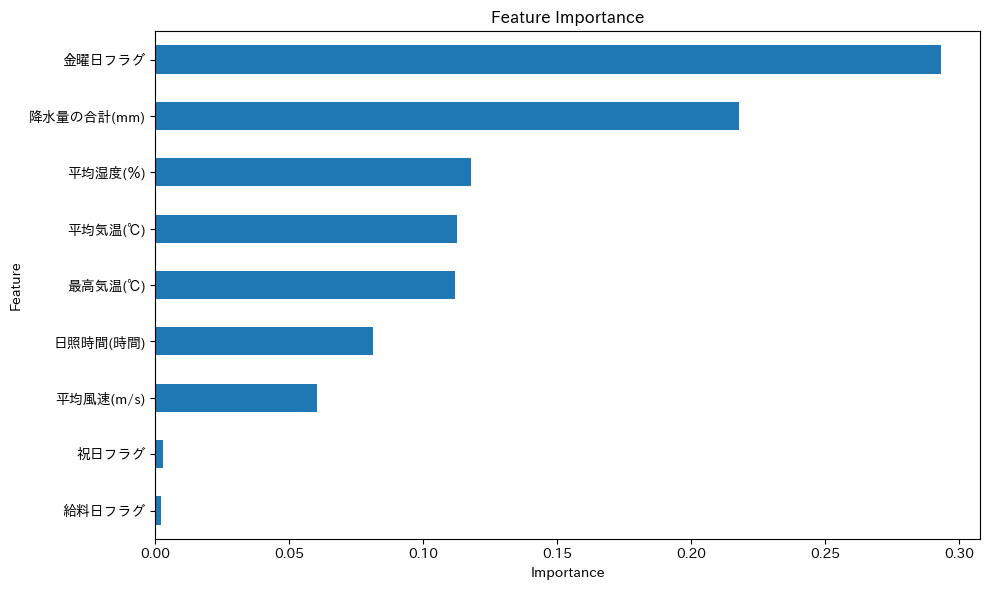

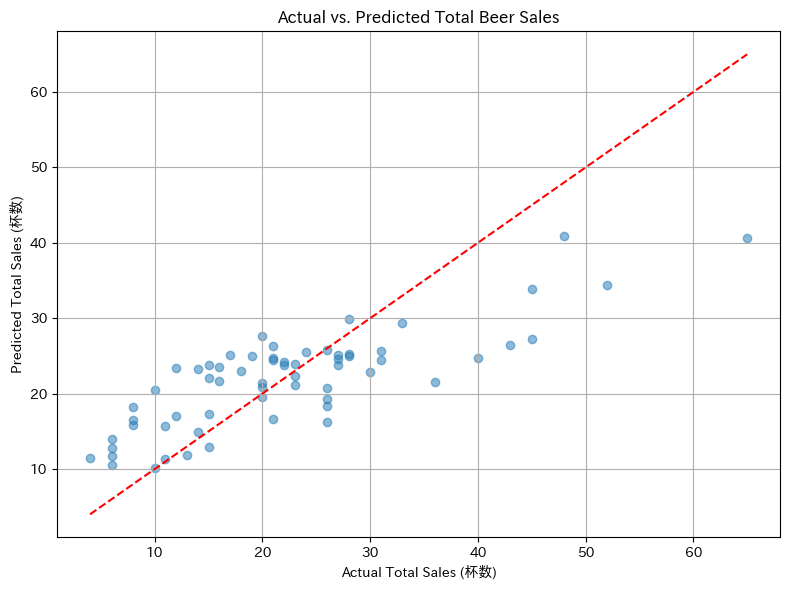

In [15]:
X = df[['給料日フラグ','祝日フラグ','金曜日フラグ', '平均気温(℃)','最高気温(℃)','降水量の合計(mm)', '日照時間(時間)', '平均風速(m/s)','平均湿度(％)' ]]  # 説明変数
y = df['総杯数'].values.ravel()
from sklearn.model_selection import train_test_split

#データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ① モデル定義と学習
model = RandomForestRegressor(
    n_estimators=150,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)

# ② 予測
y_pred = model.predict(X_test)
mean_y = y_test.mean()


# ③ 評価指標
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
relative_mae = mae / mean_y
r2_train = r2_score(y_train, model.predict(X_train))
r2_test = r2_score(y_test, model.predict(X_test))



print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAE / y_test.mean(): {relative_mae:.2%}")
print(f"学習用データの R²: {r2_train:.3f}")
print(f"テスト用データの R²: {r2_test:.3f}")


# ④ 特徴量重要度の可視化
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=True).plot(kind='barh', figsize=(10,6))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ⑤ 実測値と予測値の散布図
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Total Sales (杯数)")
plt.ylabel("Predicted Total Sales (杯数)")
plt.title("Actual vs. Predicted Total Beer Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


# 過学習対策



1.   パラメータ調整
2.   説明変数の追加 or 削減
'気温差(℃)','給料日フラグ','祝日フラグ','祝日前日フラグ', '金曜日フラグ', '平均気温(℃)','最高気温(℃)','降水量の合計(mm)', '日照時間(時間)', '平均風速(m/s)','平均湿度(％)'



MSE: 54118877.61
MAE: 5660.60
MAE / y_test.mean(): 26.73%
学習用データの R²: 0.637
テスト用データの R²: 0.587


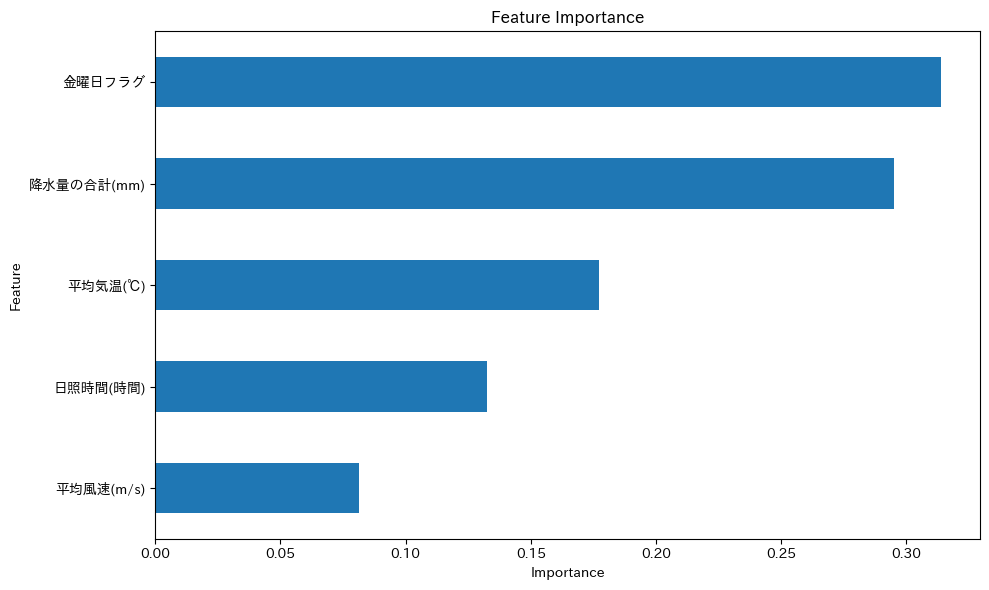

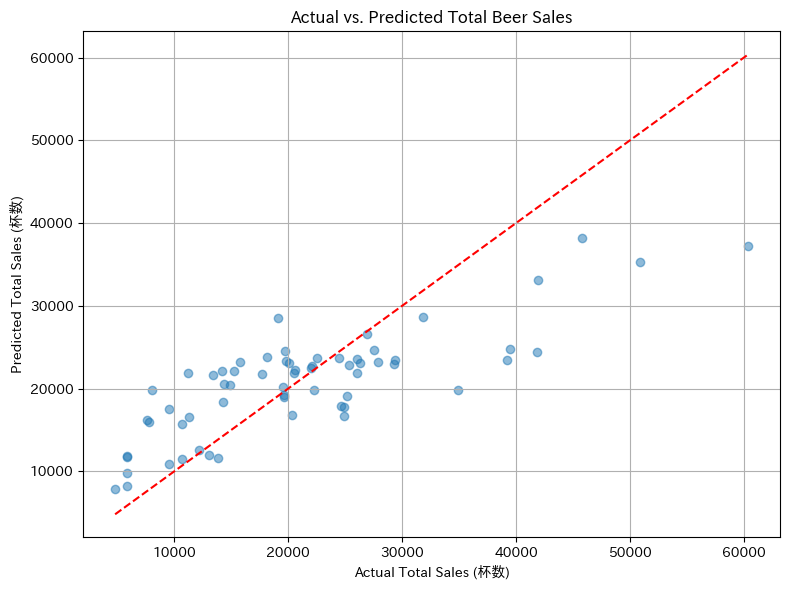

In [14]:
X = df[[ '金曜日フラグ', '平均気温(℃)','降水量の合計(mm)', '日照時間(時間)', '平均風速(m/s)' ]]  # 説明変数
y = df['売上合計(円)'].values.ravel()
from sklearn.model_selection import train_test_split

#データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ① モデル定義と学習

model = RandomForestRegressor(
    n_estimators=150,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)

# ② 予測
y_pred = model.predict(X_test)
mean_y = y_test.mean()


# ③ 評価指標
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
relative_mae = mae / mean_y
r2_train = r2_score(y_train, model.predict(X_train))
r2_test = r2_score(y_test, model.predict(X_test))



print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAE / y_test.mean(): {relative_mae:.2%}")
print(f"学習用データの R²: {r2_train:.3f}")
print(f"テスト用データの R²: {r2_test:.3f}")


# ④ 特徴量重要度の可視化
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=True).plot(kind='barh', figsize=(10,6))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ⑤ 実測値と予測値の散布図
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Total Sales (杯数)")
plt.ylabel("Predicted Total Sales (杯数)")
plt.title("Actual vs. Predicted Total Beer Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


# 各ビールごとの数値

'総杯数', 'ペールエール(本)', 'ラガー(本)', 'IPA(本)', 'ホワイトビール(本)', '黒ビール(本)','フルーツビール(本)'

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ビールの列
beer_columns = ['ペールエール(本)', 'ラガー(本)', 'IPA(本)', 'ホワイトビール(本)', '黒ビール(本)', 'フルーツビール(本)']

# 結果格納用
results = []

# 各ビールについてモデルを個別に学習・評価
for col in beer_columns:
    y = df[col]
    X = df[[ '来客数', '総杯数', '売上合計(円)', '平均気温(℃)','降水量の合計(mm)', '日照時間(時間)', '平均風速(m/s)', '平均蒸気圧(hPa)', '平均湿度(％)',
       '平均雲量(10分比)', '最高気温(℃)', '最低気温(℃)', '1時間降水量の最大(mm)', '最大風速(m/s)',
       '最小相対湿度(％)', '祝日フラグ', '給料日フラグ', '金曜日フラグ', '祝日前日フラグ']]

    # データ分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # モデル学習
    model = RandomForestRegressor(
    n_estimators=150,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)
    model.fit(X_train, y_train)

    # 予測
    y_pred = model.predict(X_test)

    # 精度指標
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # 結果保存
    results.append({
        'ビール名': col,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 2)
    })

# 結果を表示
results_df = pd.DataFrame(results)
results_df



,ビール名,MAE,RMSE,R²
0,ペールエール(本),0.78,1.03,0.85
1,ラガー(本),0.83,1.15,0.86
2,IPA(本),0.54,0.73,0.86
3,ホワイトビール(本),0.61,1.06,0.78
4,黒ビール(本),0.64,0.97,0.73
5,フルーツビール(本),1.10,1.49,0.46


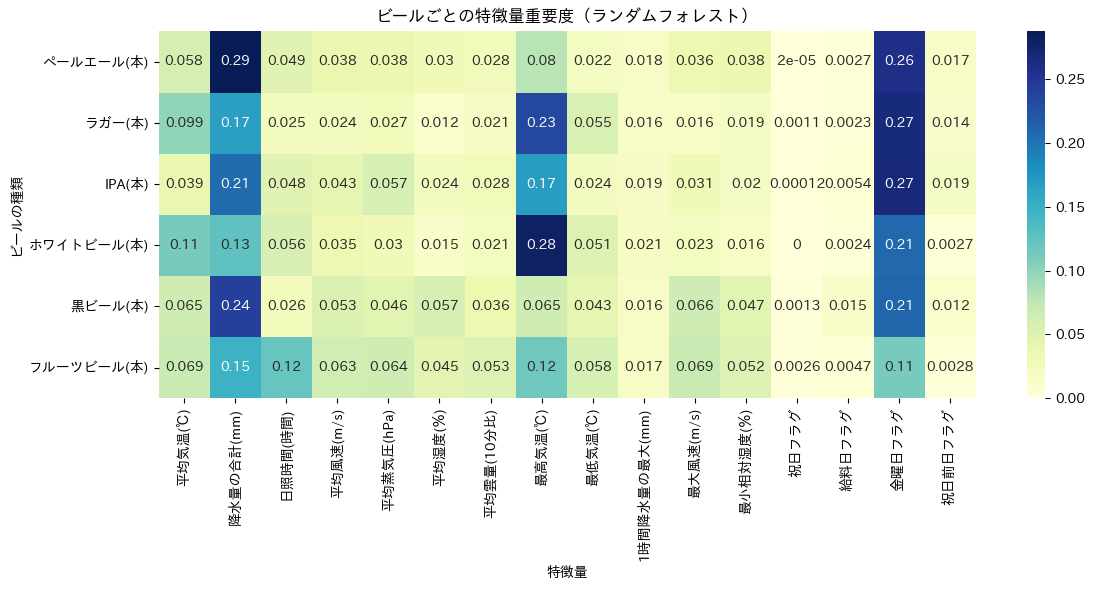

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# 説明変数と目的変数の準備
X = df[[
      '平均気温(℃)','降水量の合計(mm)', '日照時間(時間)', '平均風速(m/s)', '平均蒸気圧(hPa)', '平均湿度(％)',
       '平均雲量(10分比)', '最高気温(℃)', '最低気温(℃)', '1時間降水量の最大(mm)', '最大風速(m/s)',
       '最小相対湿度(％)', '祝日フラグ', '給料日フラグ', '金曜日フラグ', '祝日前日フラグ'
]]
beer_columns = ['ペールエール(本)', 'ラガー(本)', 'IPA(本)', 'ホワイトビール(本)', '黒ビール(本)', 'フルーツビール(本)']

# 結果格納用
feature_importances = pd.DataFrame(index=X.columns)

# ビールごとにモデルを学習して特徴量重要度を取得
for beer in beer_columns:
    y = df[beer].values.ravel()
    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X, y)
    feature_importances[beer] = model.feature_importances_

# 転置してビール×特徴量の形式に
feature_importances = feature_importances.T

# ヒートマップで可視化
plt.figure(figsize=(12, 6))
sns.heatmap(feature_importances, annot=True, cmap="YlGnBu")
plt.title("ビールごとの特徴量重要度（ランダムフォレスト）")
plt.ylabel("ビールの種類")
plt.xlabel("特徴量")
plt.tight_layout()
plt.show()
